# Dealing with imbalanced data: Credit Card Fraud Detection

Summary goes here...

## Introduction

- **Context:** In order to enhance security, credit card companies would like to reveal fraudulent transactions
- **Idea:** Use Machine Learning to identify fraudulent transactions. F

### Description of the Dataset*
The dataset contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, **we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC)**. Confusion matrix accuracy is not meaningful for unbalanced classification.

*Source: [kaggle.com](https://www.kaggle.com/mlg-ulb/creditcardfraud)

### Approach

We considered a couple of options for dealing with the imbalance problem and settled for the following three:

- Work on the full but imbalanced data set: It will be interesting to see how good models can perform on an imbalanced dataset.
- Work on undersampled data set: Undersampling will yield balanced classes but with the cost of loss of information.
- Work on the full over-sampled data set: Oversampling will also yield balanced classes but with a lot of data that makes training computationally expensive.

In the banking context regulation plays a big role and therefore model explainability is very important.
We choose a Logistic Regression in order to keep the model simple. The Logistic Regression performed better in early testing then a Random Forest.

Instead of comparing many models we focused on the data preparation.
- The Logistic Regression has been tested on the following data:
- Fully imbalanced set (1)
- Latent representation (from Autoencoder) of fully imbalanced set 
- Under-sampled set (3)
- Over-sampled set (4)

## Prerequisites

In [52]:
import numpy as np

2.1.0


### Helper Function for Model Evaluation

In [ ]:
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve
import matplotlib.pyplot as plt

In [6]:
def evaluate_model(clf, X_test, y_test, name='Not specified'):
    
    print(f"Class distribution in test data:\nNormal: {len(y_test[y_test==0])}\nFraud: {len(y_test[y_test==1])}")
    
    fig, axes = plt.subplots(1,2, figsize=(20,6))
    
    # Confusion Matrix
    plot_confusion_matrix(clf, X_test, y_test, normalize=None,
                          display_labels=['Normal', 'Fraud'], cmap='Greens', ax=axes[0])
    axes[0].set_title('Confusion Matrix\n')
    
    plot_confusion_matrix(clf, X_test, y_test, normalize='true',
                          display_labels=['Normal', 'Fraud'], cmap='Greens', ax=axes[1])
    axes[1].set_title('Confusion Matrix\nnormalized')
    
    # Precision Recall Curve
    plot_precision_recall_curve(clf, X_test, y_test, name=name)
    plt.title('Precision Recall Curve')

### Import Dataset

In [ ]:
import pandas as pd
import json
import zipfile
from pathlib import Path

In [7]:
def load_data():
    """ Unzip archive if necessary, import the data and return a Dataframe """
    
    data_dir = Path.cwd() / 'data'
    # print(f"Data files can be found in '{data_dir}'")
    
    csv_file = Path(data_dir/'creditcard.csv')
    zip_file = Path(data_dir/'creditcard.zip')
    
    if not csv_file.exists() and zip_file.exists():
        with zipfile.ZipFile(zip_file,"r") as zip_ref:
            # print(f"Extracting archive {zip_file.name} to {csv_file.name}")
            zip_ref.extractall(data_dir)        
        
    # print(f"Loading data from file '{csv_file.name}'")
    return pd.read_csv(csv_file)

In [8]:
df = load_data()
print(f"Rows: {df.shape[0]}")
print(f"Cols: {df.shape[1]}")

Rows: 284807
Cols: 31


### Split into Train and Test set

In [55]:
from sklearn.model_selection import train_test_split
seed = 1

X_orig = df.drop('Class', axis=1)
y_orig = df.Class

X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.2,
                                                    random_state=seed, stratify=y_orig)

In [22]:
print(f"Train samples: {y_train.shape[0]}")
print(f"Test samples: {y_test.shape[0]}")
print(f"Ratio: {y_test.shape[0]/y_orig.shape[0]:.2f}")

Train samples: 227845
Test samples: 56962
Ratio: 0.20


## Scaling the data while avoiding Data Leakage
Yes, you saw right, we did not scale the data before the split. In order to avoid information from the training data [leaking](https://machinelearningmastery.com/data-leakage-machine-learning/) into the test set we will do this later. I see people far too often scaling their whole dataset before the model training. This may improve your models performance in an unwanted manner and should be avoided. Instead one should do it like this:
 - Create the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) object
 - Fit scaler on the training data and transform it
 - Transform the test data without fitting the scaler again

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Since we will be using cross validation in this notebook, we also have to make sure that we are scaling the date after creating the folds, such that the validation set does not know about the distribution in the training set either. Luckily sklearns [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) helps us with that: it will fit the scaler only on the training folds.

## Train a simple Model
Let's create a simple Logistic Regression model to see how things go. We will not compare multiple models but rather focus on dealing with the imbalance in this dataset. To estimate the models performance we use [cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) with [average precision score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score).

In [70]:
# global stuff
metric = 'average_precision'

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

simple_lr = LogisticRegression(max_iter=500) # increased max_iter to allow lbfgs-solver converging

simple_p = Pipeline([('transformer', scaler), ('estimator', simple_lr)])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

score = cross_val_score(simple_p, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
print(f"Simple model mean average precision: {np.mean(score):.4f}")

Simple model mean average precision: 0.7464


## Optimizing the model

In [113]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(max_iter=500, multi_class='ovr', n_jobs=-1, random_state=seed)
p = Pipeline([('transformer', scaler), ('estimator', lr)])

param_grid = {'estimator__C':  np.logspace(-4, 4, 5), # as in sklearn.LogisticRegressionCV
              'estimator__class_weight': [None, 'balanced']}

grid_search = GridSearchCV(p, param_grid, scoring=metric, n_jobs=-1, cv=cv, verbose=2)

In [108]:
grid_search.fit(X_train, y_train)
print(f"Optimized model mean average precision: {np.mean(grid_search.best_score_):.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   49.8s finished


Optimized model mean average precision: 0.7465


## Autoencoder + Logistic Regression
Here we are using the Autoencoder for dimensionality reduction rather then anomaly detection
 - Should we compare it with PCA or t-sne?
 - How does classification via reconstruction error work?

What is a good number of (normal) examples for the Autoencoder training?
 - How many examples do we need to train the logistic regression?
 - Because AE is a neural network, probably the more examples the better

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
print(tf.__version__)

tf.random.set_seed(42)

### Prepare Data for Autoencoder

In [8]:
# Get normal transactions
X_train_norm = X_train[y_train == 0]
print(f"Training data contains {X_train_norm.shape[0]} normal transactions")

Training data contains 227451 normal transactions


In [9]:
# Take a fraction of that for training the Autoencoder
X_train_AE = X_train_norm.sample(frac=0.5, random_state=seed)

# Scale the data
X_train_AE_scaled = StandardScaler().fit_transform(X_train_AE)

### Create and Train Autoencoder Model

In [10]:
# set parameters for model loading/saving/training
load_model = True
num_epochs = 500
model_dir = f'models/autoencoder_{num_epochs}/'
print("Saving models in 'model_dir'")

Saving models in 'model_dir'


In [11]:
# load model
if load_model:
    model = tf.keras.models.load_model(model_dir)
    with open(model_dir + 'trainHistoryDict.json', 'r') as f:
        history = json.load(f)
    model.summary()

When training the Autoencoder do we need a validation data?

In [12]:
def create_model(input_dim=30, latent_dim=50):
    """ Creates an Autoencoder Model where input_dim is the number of features.
    The encoding part uses L1-regularization as sparsity constraint """
    
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(100, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    latent =  Dense(latent_dim, activation='relu')(encoded)
    decoded = Dense(100, activation='relu')(latent)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    
    return Model(input_layer, output_layer)

In [13]:
if not load_model:
    model = create_model()
    model.compile(optimizer="adadelta", loss="mse")
    model.summary()
    
    history = model.fit(X_train_AE_scaled, X_train_AE_scaled,
                        batch_size=64, epochs=num_epochs, verbose=0, validation_split=0.05,
                        callbacks=[TqdmCallback(), EarlyStopping(patience=3)])
    history = history.history

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                3030      
Total params: 16,280
Trainable params: 16,280
Non-trainable params: 0
_________________________________________________________________


In [14]:
if not load_model:
    # save model
    model.save(model_dir)

    # save history
    import json
    with open(model_dir + 'trainHistoryDict.json', 'w') as f:
        json.dump(history, f)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/autoencoder_500/assets


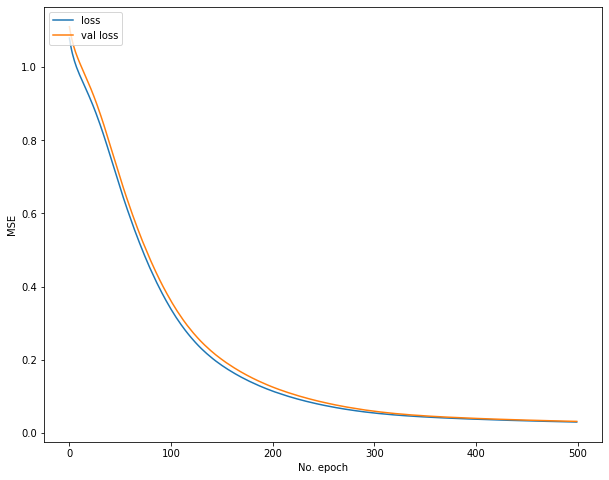

In [15]:
# Plot history
plt.figure(figsize=(10,8))
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val loss')
plt.ylabel('MSE')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

### Create Encoder Model and Extract Latent Representation

In [16]:
encoder = Sequential([model.layers[0],
                      model.layers[1],
                      model.layers[2]])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
Total params: 8,150
Trainable params: 8,150
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Remove AE samples from training data for classifier
X_train_clf = X_train.drop(X_train_AE.index)
y_train_clf = y_train.drop(X_train_AE.index)

In [18]:
# Scale data 
X_train_clf_scaled = StandardScaler().fit_transform(X_train_clf)

# Extract latent representation
X_train_clf_lat = encoder.predict(X_train_clf_scaled)

### Logistic Regression CV with latent data

In [59]:
# define hyperparameters
K = 5

# scoring is usually 'recall' but average precision is area under precision-recall curve
scoring = 'recall'

parameters = {
    'C':  np.logspace(-4, 4, 5) # as in sklearn.LogisticRegressionCV
#    'max_iter': [500],
    'class_weight': [None, 'balanced'],
    'solver': ['lbfgs', 'saga'],
    'penalty': ['l1', 'l2']
}

In [60]:
#TODO lr_model_2 = LogisticRegressionCV()

In [61]:
# perform CV: one-vs-rest scheme
GSCV_2 = GridSearchCV(LogisticRegression(multi_class='ovr', random_state=seed),
                      cv=K, param_grid=parameters, scoring=scoring, n_jobs=-1, verbose=2)

GSCV_2.fit(X_train_clf_lat, y_train_clf)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 25.7min finished
D:\Miniconda3\envs\py37-tf2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=1, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 10, 100], 'class_weight': [None, 'balanced'],
                         'max_iter': [500], 'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='average_precision', verbose=2)

In [62]:
# CV results
clf_2 = GSCV_2.best_estimator_
GSCV_2.best_score_

0.8242973626169601

In [64]:
np.logspace(-4, 4, 5)

NameError: name 'np' is not defined

In [63]:
clf_2

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=1,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

### Evaluate LR Model

In [68]:
# Scale data 
X_test_clf_scaled = StandardScaler().fit_transform(X_test)

# Extract latent representation
X_test_clf_lat = encoder.predict(X_test_clf_scaled)

Class distribution in test data:
Normal: 56864
Fraud: 98


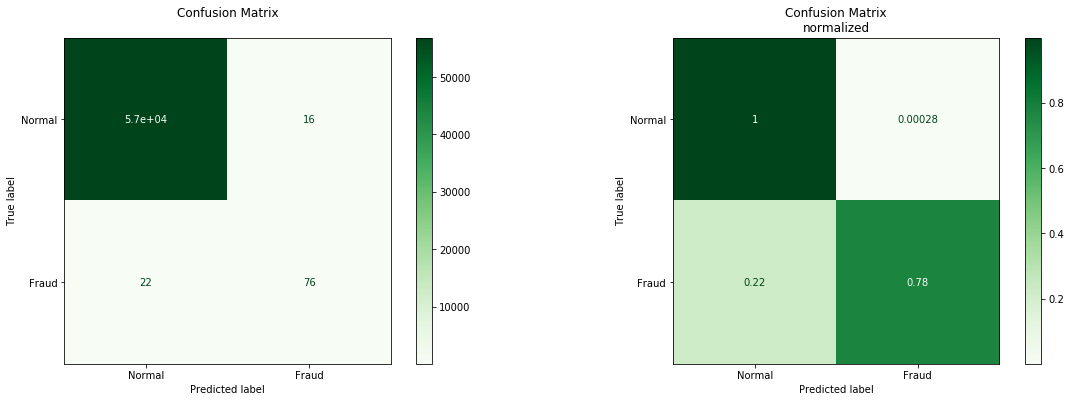

<Figure size 864x576 with 0 Axes>

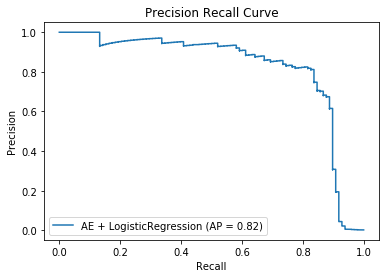

In [73]:
evaluate_model(clf_2, X_test_clf_lat, y_test, 'AE + LogisticRegression')